# Model hiper optimization

<h1 style="color:red">Don't use. Use separated model by tipo_exped</h1>

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [140]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.0 - total_condiciones_split lw4 - recall with zone groups"

pd.set_option("display.max_columns", 500)

path = "../../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [3]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [4]:
# using only last year
split_date = "2018-01-01"
df = df[df["FECHA_SINI"] >= split_date].copy()

In [5]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [6]:
pd.crosstab(df["total_condicion"], df["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,464245,827
1.0,22687,27
2.0,4198,98
3.0,18620,225
4.0,1828,24
5.0,2050,517
6.0,479,53
7.0,153,83
8.0,137,67


In [7]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df = df[(df["total_condicion"] < 4)]
df_val = df_val[(df_val["total_condicion"] < 4)]

In [8]:
pd.crosstab(df["total_condicion"], df["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,464245,827
1.0,22687,27
2.0,4198,98
3.0,18620,225


In [9]:
df["TIPO_EXPED"].value_counts()

2    224888
3    202970
1     39627
6     30066
4      6556
5      4160
0      2660
Name: TIPO_EXPED, dtype: int64

In [10]:
# delete unique value columns (for tipo_exped == 060)
use_cols = df.nunique()[df.nunique() > 1].index
df = df[use_cols]
df_val = df_val[use_cols]

In [11]:
cond_cols = df.filter(regex="^cond_*").columns
cond_cols

Index(['cond_04', 'cond_05', 'cond_06', 'cond_09', 'cond_11', 'cond_12',
       'cond_32', 'cond_37', 'cond_C1', 'cond_C10', 'cond_C11', 'cond_C12',
       'cond_C13', 'cond_C14', 'cond_C15', 'cond_C16', 'cond_C17', 'cond_C18',
       'cond_C19', 'cond_C2', 'cond_C20', 'cond_C21', 'cond_C3', 'cond_C4',
       'cond_C5', 'cond_C6', 'cond_C7', 'cond_C8', 'cond_C9'],
      dtype='object')

In [12]:
# create column number of conditions activated
df["cant_cond"] = (df[cond_cols] > 0).sum(axis=1)
df_val["cant_cond"] = (df_val[cond_cols] > 0).sum(axis=1)

In [13]:
df["cant_cond"].value_counts()

0    465072
1     44391
2      1422
3        42
Name: cant_cond, dtype: int64

In [14]:
df["EXISTE_FRAUDE"].value_counts()

False    509750
True       1177
Name: EXISTE_FRAUDE, dtype: int64

In [15]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [16]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [17]:
pd.crosstab(df["FECHA_SINI"].dt.month, [df["EXISTE_FRAUDE"], df["TIPO_EXPED"]], margins=True)

EXISTE_FRAUDE False                                           True           \
TIPO_EXPED        0      1       2       3     4     5      6    0    1   2   
FECHA_SINI                                                                    
1               359   5153   29449   30453  1025   604   5283    0   22   6   
2               223   2801   14765   13112   445   321   1874    1   11   4   
3               238   3644   18569   26327   686   352   2087    0   13   7   
4               235   3229   17569   15462   476   356   1943    2   12   7   
5               200   3372   18843   14489   424   329   2229    1   19   3   
6               199   3273   18405   13383   468   321   1893    1    6   9   
7               176   2919   18272   14154   491   327   2205    0   17   5   
8               172   3244   18890   14818   458   305   2290    1    9   2   
9               218   2941   16992   14622   498   313   2359    1   11   5   
10              206   3221   18225   16072   489   291   2560    1    5   2   
11              195   2904   16956   14431   485   262   2224    0    3   2   
12              230   2795   17898   15595   585   246   2348    1    3   3   
All            2651  39496  224833  202918  6530  4027  29295    9  131  55   

EXISTE_FRAUDE                       All  
TIPO_EXPED      3   4    5    6          
FECHA_SINI                               
1               4   6   19  125   72508  
2               4   1   10   47   33619  
3               4   3   11   46   51987  
4               4   2   18   51   39366  
5               5   3   16   53   39986  
6               3   2    7   57   38027  
7               4   3   13   94   38680  
8               4   1   11   73   40278  
9               4   1    5   72   38042  
10              5   1    7   52   41137  
11              5   0   12   55   37534  
12              6   3    4   46   39763  
All            52  26  133  771  510927

In [18]:
# using only last year
split_date = "2018-11-01"
df_train = df[df["FECHA_SINI"] < split_date].copy()
df_opt = df[df["FECHA_SINI"] >= split_date].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-01-01 00:00:00 2018-10-31 00:00:00
2018-11-01 00:00:00 2019-01-31 00:00:00


In [19]:
df_train["EXISTE_FRAUDE"].value_counts(normalize=True), df_opt["EXISTE_FRAUDE"].value_counts(normalize=True)

(False    0.997551
 True     0.002449
 Name: EXISTE_FRAUDE, dtype: float64, False    0.998214
 True     0.001786
 Name: EXISTE_FRAUDE, dtype: float64)

In [20]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.7808571478900117, 0.21914285210998832)

In [21]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [22]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"] # , "es_gte_5"

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [23]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [24]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [25]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

398961, 111966
398961, 111966


In [26]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.0024488609162299072, 0.0017862565421645858)

In [27]:
y_train.value_counts(dropna=False)

False    397984
True        977
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [28]:
from sklearn.utils.class_weight import compute_class_weight

In [29]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([  0.50115449, 217.04630416])

In [95]:
# configs
list_weights = [180, 200] # , 350
[{0:1, 1:l} for l in list_weights]

[{0: 1, 1: 180}, {0: 1, 1: 200}]

### VERSION SIMPLE

In [97]:

rf_params = {
    "n_estimators": [40],
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt'],  # , None
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
# param_configs.append(rf_params)
# param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': [60, 100], 
#    "min_samples_leaf": [3, 5, 7],
#    "max_depth": [10, 40], # 10,
#    'min_samples_split': [5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bynode": [0.5 , 1],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': [60, 100], 
#    'num_leaves': [10, 20, 50],
#    'max_depth': [5, 10, 30],
#    'min_child_samples': [3, 5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bytree": [0.5 , 1],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}

param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'scale_pos_weight': [180, 200]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'class_weight': [{0: 1, 1: 180}, {0: 1, 1: 200}]}]

### VERSION COMPLEJA

In [98]:
n_estimators = [60, 200]

rf_params = {
    "n_estimators": [60],
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
# param_configs.append(rf_params)
# param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': n_estimators, 
    "max_depth": [15, 40, 5],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': n_estimators, 
#    'num_leaves': [10, 20, 50],
    "max_depth": [15, 40, -1],
    'min_child_samples': [3, 5, 7, 11],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60, 200],
  'max_depth': [15, 40, 5],
  'learning_rate': [1.0, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'scale_pos_weight': [180, 200]},
 {'n_estimators': [60, 200],
  'max_depth': [15, 40, -1],
  'min_child_samples': [3, 5, 7, 11],
  'learning_rate': [1.0, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'class_weight': [{0: 1, 1: 180}, {0: 1, 1: 200}]}]

### Optimizing

In [99]:
# using without grid with list of models
rfs = []
# rfs.append(RandomForestClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(DecisionTreeClassifier(random_state=random_state))
rfs.append(XGBClassifier(random_state=random_state, n_jobs=-1))
rfs.append(LGBMClassifier(random_state=random_state, silent=False, n_jobs=-1))
rfs

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=-1, nthread=None, objective='binary:logistic',
               random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=True, subsample=1),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]

In [100]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "recall"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=param_configs[counter], seed=random_state, num_threads=1)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Comparing 96 parameter setting(s) using 1 CPU thread(s) ( 96 job(s) per thread ).
Best score: 0.725
Best config: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 200}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 1: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=

In [101]:
print("Best Config:")
for m, s in zip(best_models_, best_scores_):
    print(m, s)

Best Config:
GridSearch(cv_folds=3,
           model=XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=1.0,
                               gamma=0, learning_rate=0.01, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               n_estimators=200, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=200,
                               seed=0, silent=True, subsample=1),
           num_threads=1,
           param_grid={'colsample_bytree': [0.5, 1.0],
                       'learning_rate': [1.0, 0.1, 0.05, 0.01],
                       'max_depth': [15, 40, 5], 'n_estimators': [60, 200],
                       'scale_pos_weight': [180, 200]},
           seed=42) 0.725
GridSearch(cv_folds=3,
           model=LGBMClassifier(boosting_type='g

In [102]:
# select best grid
best_model = best_models_[np.argmax(best_scores_)]

# select by hand
# best_model = best_models_[2]

In [103]:
sorted_ids = np.argsort(best_model.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (best_model.scores[i], best_model.params[i]))

Grid scores:
0.785 for {'class_weight': {0: 1, 1: 200}, 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 7, 'n_estimators': 200}
0.785 for {'class_weight': {0: 1, 1: 180}, 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 5, 'n_estimators': 200}
0.785 for {'class_weight': {0: 1, 1: 200}, 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 40, 'min_child_samples': 11, 'n_estimators': 200}
0.785 for {'class_weight': {0: 1, 1: 200}, 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 40, 'min_child_samples': 7, 'n_estimators': 200}
0.785 for {'class_weight': {0: 1, 1: 200}, 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 11, 'n_estimators': 200}
0.785 for {'class_weight': {0: 1, 1: 200}, 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 7, 'n_estimators': 200}
0.785 for {'class_weight': {0: 1, 1: 200}, 'colsample_bytree': 0.5,

In [104]:
y_opt_pred = best_model.predict(X_opt)
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred), roc_auc_score(y_opt, y_opt_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.044173863797253285, 0.859995347422293)

In [105]:
confusion_matrix(y_opt, y_opt_pred)

array([[105059,   6707],
       [    44,    156]])

array([[104635,   7131],
       [    46,    154]])

In [106]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                555     1     1     0
1               8007     2     7     0
2              48886     0     5     0
3              44766     3    13     0
4               1546    16     4     1
5                650   147     8    14
6                649  6538     6   141

In [78]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                546    10     0     1
1               7703   306     6     1
2              48861    25     5     0
3              44768     1    13     0
4               1492    70     5     0
5                667   130     8    14
6                598  6589     9   138

**Tronador**

In [48]:
confusion_matrix(y_opt, X_opt["total_condicion"] >= 5)

array([[111766,      0],
       [   200,      0]])

In [49]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], X_opt["total_condicion"] >= 5])

EXISTE_FRAUDE,False,True
total_condicion,False,False
TIPO_EXPED,,
0,556,1
1,8009,7
2,48886,5
3,44769,13
4,1562,5
5,797,22
6,7187,147


## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

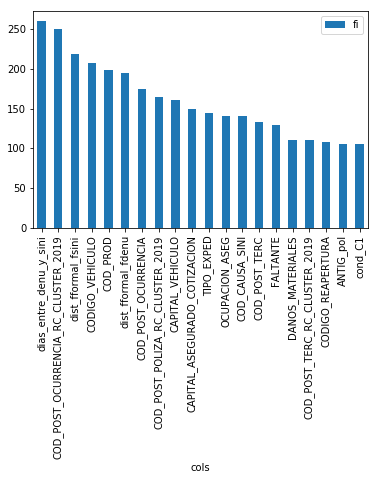

In [107]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [119]:
to_keep = list(rf_fi[rf_fi["fi"] >=15]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 77 of 148


In [120]:
"""to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep"""

'to_remove = [\'COD_POST_POLIZA_RT_CLUSTER_2019\', \'COD_POST_OCURRENCIA_RT_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_RC_CLUSTER_2019\',  \'COD_POST_POLIZA_RC_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_DP_CLUSTER_2019\', \'COD_POST_POLIZA_DP_CLUSTER_2019\',\n             "COD_CAUSA_SINI", \n            ] # "es_gte_5", "total_condicion", \n\nfor col in to_remove:\n    if(col in to_keep):\n        to_keep.remove(col)\nto_keep'

In [121]:
# best model
best_model.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 180},
               colsample_bytree=0.5, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=11,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
               n_jobs=-1, num_leaves=31, objective=None, random_state=0,
               reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### Training again with less features

In [122]:
X_train_red = X_train[to_keep].copy()
print(len(X_train_red.columns))

77


In [123]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(best_model.best_estimator_)
rf.fit(X_train_red, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 180},
               colsample_bytree=0.5, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=11,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
               n_jobs=-1, num_leaves=31, objective=None, random_state=0,
               reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [124]:
y_opt_pred = rf.predict(X_opt[to_keep])
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred), roc_auc_score(y_opt, y_opt_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.04370477568740955, 0.8481574450190575)

In [125]:
confusion_matrix(y_opt, y_opt_pred)

array([[105207,   6559],
       [    49,    151]])

array([[103320,   8446],
       [    28,    172]])

In [126]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                556     0     1     0
1               8009     0     7     0
2              48886     0     5     0
3              44767     2    13     0
4               1538    24     5     0
5                655   142     8    14
6                796  6391    10   137

In [87]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                546    10     0     1
1               7703   306     6     1
2              48861    25     5     0
3              44768     1    13     0
4               1492    70     5     0
5                667   130     8    14
6                598  6589     9   138

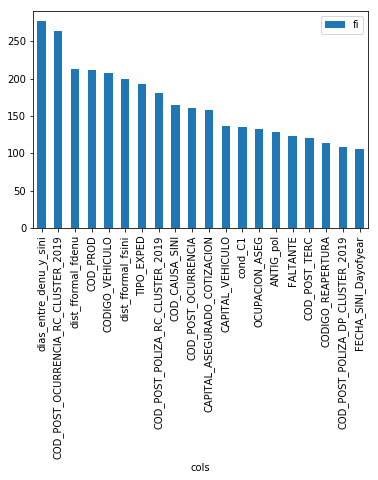

In [127]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# model with validation set

## full features final model

In [77]:
rf_full = copy(best_model)
rf_full.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [78]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.468, 0.905


In [79]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4475,  388],
       [  69,  201]])

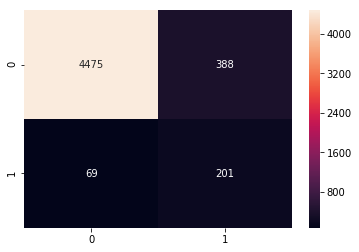

In [80]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [128]:
rf_full = copy(best_model.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 180},
               colsample_bytree=0.5, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=11,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
               n_jobs=-1, num_leaves=31, objective=None, random_state=0,
               reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [129]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.035, 0.951


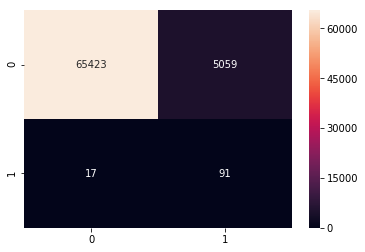

In [130]:
conf_mat = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [131]:
pd.crosstab(X_val["TIPO_EXPED"], [y_val, y_val_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                379     0     2     0
1               5187     0     7     0
2              30794     0     3     0
3              28079     6     4     0
4                867    64     0     1
5                  5   625     0    17
6                112  4364     1    73

In [156]:
# run this to save the reduce model
best_model = copy(rf_full)

## Tronador (sum cond >=5) comparison

In [67]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.0,0.5)


/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


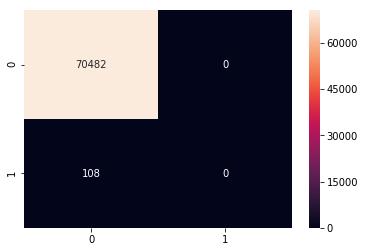

In [68]:
conf_mat = confusion_matrix(y_val, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Model % sec != 0.5

0.070, 0.951


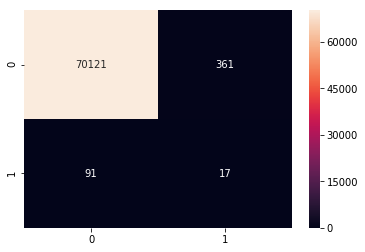

In [136]:
porc_sec = 0.76
y_val_pred = y_val_pred_prob >= porc_sec
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)
conf_mat = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [137]:
pd.crosstab(X_val["TIPO_EXPED"], [y_val, y_val_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                379     0     2     0
1               5187     0     7     0
2              30794     0     3     0
3              28085     0     4     0
4                931     0     1     0
5                630     0    17     0
6               4115   361    57    17

# Saving final model & columns used into hard drive

In [141]:
path_to_save = f"models/{model_id}/"
os.makedirs(path_to_save, exist_ok=True)

In [157]:
model_file = os.path.join(path_to_save, f"{model_id}.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, pickle.HIGHEST_PROTOCOL)

In [158]:
# save file for humans
model_file = os.path.join(path_to_save, f"{model_id} - readable.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, 0) # 0 is human readable format

In [143]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['dias_entre_denu_y_sini', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'dist_fformal_fsini', 'CODIGO_VEHICULO', 'COD_PROD', 'dist_fformal_fdenu', 'COD_POST_OCURRENCIA', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'CAPITAL_VEHICULO', 'CAPITAL_ASEGURADO_COTIZACION', 'TIPO_EXPED', 'OCUPACION_ASEG', 'COD_CAUSA_SINI', 'COD_POST_TERC', 'FALTANTE', 'DANOS_MATERIALES', 'COD_POST_TERC_RC_CLUSTER_2019', 'CODIGO_REAPERTURA', 'ANTIG_pol', 'cond_C1', 'TIPO_LESION', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'CANT_RENOVACION', 'COD_POST_POLIZA', 'ESTADO_CIVIL', 'FECHA_SINI_Dayofyear', 'TELEFONO_TERC', 'TIPO_SINIESTRO', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'cond_C6', 'FECHA_SINI_Day', 'CONV_COMISIONARIO', 'FECHA_SINI_Elapsed', 'cond_C15', 'CAPITAL_ACCESORIOS', 'cond_C10', 'preg_15', 'MCA_JUICIO', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'FECHA_SINI_Dayofweek', 'CODIGO_CARATULA', 'COD_POST_TERC_DP_CLUSTER_2019', 'COD_ZONA_RC', 'cond_C14', 'SEXO', 'NEGOCIO', 'DESCRIPCION_TIPO', 'cant_cond'

In [144]:
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - n_features_{len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [120]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [138]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [139]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df_test = df_test[(df_test["total_condicion"] < 4)]

In [145]:
# Loding the model

def load_model(model_file):
    """Load the dump model."""
    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [159]:
m = load_model(model_file)
columns = load_columns(columns_file)

In [147]:
print(columns)

['dias_entre_denu_y_sini', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'dist_fformal_fsini', 'CODIGO_VEHICULO', 'COD_PROD', 'dist_fformal_fdenu', 'COD_POST_OCURRENCIA', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'CAPITAL_VEHICULO', 'CAPITAL_ASEGURADO_COTIZACION', 'TIPO_EXPED', 'OCUPACION_ASEG', 'COD_CAUSA_SINI', 'COD_POST_TERC', 'FALTANTE', 'DANOS_MATERIALES', 'COD_POST_TERC_RC_CLUSTER_2019', 'CODIGO_REAPERTURA', 'ANTIG_pol', 'cond_C1', 'TIPO_LESION', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'CANT_RENOVACION', 'COD_POST_POLIZA', 'ESTADO_CIVIL', 'FECHA_SINI_Dayofyear', 'TELEFONO_TERC', 'TIPO_SINIESTRO', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'cond_C6', 'FECHA_SINI_Day', 'CONV_COMISIONARIO', 'FECHA_SINI_Elapsed', 'cond_C15', 'CAPITAL_ACCESORIOS', 'cond_C10', 'preg_15', 'MCA_JUICIO', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'FECHA_SINI_Dayofweek', 'CODIGO_CARATULA', 'COD_POST_TERC_DP_CLUSTER_2019', 'COD_ZONA_RC', 'cond_C14', 'SEXO', 'NEGOCIO', 'DESCRIPCION_TIPO', 'cant_cond'

In [152]:
# create cant_cond column
cond_cols = df.filter(regex="^cond_").columns
df_test["cant_cond"] = (df_test[cond_cols] > 0).sum(axis=1)
df_test["cant_cond"].value_counts(dropna=False)

0    27870
1     5928
2      354
3       17
Name: cant_cond, dtype: int64

In [153]:
X_test = df_test[columns]
y_test = df_test["EXISTE_FRAUDE"]

In [154]:
X_test.head()

,dias_entre_denu_y_sini,COD_POST_OCURRENCIA_RC_CLUSTER_2019,dist_fformal_fsini,CODIGO_VEHICULO,COD_PROD,dist_fformal_fdenu,COD_POST_OCURRENCIA,COD_POST_POLIZA_RC_CLUSTER_2019,CAPITAL_VEHICULO,CAPITAL_ASEGURADO_COTIZACION,TIPO_EXPED,OCUPACION_ASEG,COD_CAUSA_SINI,COD_POST_TERC,FALTANTE,DANOS_MATERIALES,COD_POST_TERC_RC_CLUSTER_2019,CODIGO_REAPERTURA,ANTIG_pol,cond_C1,TIPO_LESION,COD_POST_POLIZA_DP_CLUSTER_2019,CANT_RENOVACION,COD_POST_POLIZA,ESTADO_CIVIL,FECHA_SINI_Dayofyear,TELEFONO_TERC,TIPO_SINIESTRO,COD_POST_POLIZA_RT_CLUSTER_2019,COD_POST_OCURRENCIA_DP_CLUSTER_2019,cond_C6,FECHA_SINI_Day,CONV_COMISIONARIO,FECHA_SINI_Elapsed,cond_C15,CAPITAL_ACCESORIOS,cond_C10,preg_15,MCA_JUICIO,COD_POST_OCURRENCIA_RT_CLUSTER_2019,FECHA_SINI_Dayofweek,CODIGO_CARATULA,COD_POST_TERC_DP_CLUSTER_2019,COD_ZONA_RC,cond_C14,SEXO,NEGOCIO,DESCRIPCION_TIPO,cant_cond,cond_37,ESTAD_VEH_ASEG,preg_9,cond_C7,cond_C13,COD_POST_TERC_RT_CLUSTER_2019,cond_C16,cond_C9,total_condicion,TIPO_LESION_MAXIMA,cond_11,SEGMENTO,preg_34,FECHA_SINI_Week,cond_C11,COD_ZONA_ROBO,cond_C8,cond_12,existe_FECHA_FORMAL,cond_09,COD_ZONA_CASCO,cant_sini_1y,PRENDARIO,SEXO_TERC,COD_COBRO_ANTERIOR,CERRADURA_DERECHA,CERRADURA_BAUL,COD_COBRO
0,0.0,26.0,-1.0,18380.0,73747.0,-1.0,1439.0,26.0,4514,2293,3,44.0,226.0,-1.0,1,0,-1.0,-1.0,699.0,-1.0,-1,28.0,24.0,1439.0,0,91.0,-1,5,8.0,28.0,-1.0,1.0,23,1554076800,0.0,8,-1.0,-1,-1,8.0,0.0,-1.0,-1.0,1.0,-1.0,1,21,3,0,-1.0,5.0,-1,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1,-1.0,5,-1,14.0,-1.0,3.0,-1.0,-1.0,0,-1.0,1.0,0.0,0,-1,0,0,0,0
1,0.0,26.0,-1.0,6846.0,5350.0,-1.0,1708.0,26.0,3913,1985,3,5.0,226.0,-1.0,1,0,-1.0,-1.0,1216.0,-1.0,-1,25.0,41.0,1684.0,0,91.0,-1,5,8.0,25.0,-1.0,1.0,107,1554076800,0.0,8,-1.0,-1,-1,8.0,0.0,-1.0,-1.0,1.0,-1.0,1,21,3,0,-1.0,3.0,-1,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1,-1.0,4,-1,14.0,-1.0,1.0,-1.0,-1.0,0,-1.0,1.0,0.0,0,-1,0,0,0,0
3,0.0,8.0,-1.0,5611.0,72948.0,-1.0,5178.0,8.0,4838,2359,2,44.0,501.0,-1.0,1,0,-1.0,-1.0,28.0,0.0,-1,8.0,2.0,5178.0,6,91.0,-1,9,3.0,8.0,0.0,1.0,106,1554076800,0.0,8,-1.0,-1,-1,3.0,0.0,-1.0,-1.0,30.0,-1.0,1,21,3,0,-1.0,3.0,-1,0.0,-1.0,-1.0,0.0,0.0,0.0,-1,-1.0,5,-1,14.0,-1.0,30.0,0.0,-1.0,0,-1.0,11.0,0.0,0,1,5,-1,-1,5
4,0.0,8.0,-1.0,5611.0,72948.0,-1.0,5178.0,8.0,4838,2359,3,44.0,501.0,-1.0,1,0,-1.0,1.0,28.0,-1.0,-1,8.0,2.0,5178.0,6,91.0,-1,9,3.0,8.0,-1.0,1.0,106,1554076800,0.0,8,-1.0,-1,-1,3.0,0.0,-1.0,-1.0,30.0,-1.0,1,21,3,0,-1.0,3.0,-1,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1,-1.0,5,-1,14.0,-1.0,30.0,-1.0,-1.0,0,-1.0,11.0,0.0,0,-1,5,0,0,5
5,0.0,25.0,-1.0,2114.0,72189.0,-1.0,1778.0,25.0,5899,2653,2,5.0,501.0,-1.0,1,0,-1.0,-1.0,88.0,0.0,-1,29.0,4.0,1766.0,0,91.0,-1,4,10.0,29.0,0.0,1.0,32,1554076800,0.0,8,-1.0,-1,-1,10.0,0.0,-1.0,-1.0,1.0,-1.0,0,50,3,0,-1.0,5.0,-1,0.0,-1.0,-1.0,0.0,0.0,0.0,-1,-1.0,-1,-1,14.0,-1.0,1.0,0.0,-1.0,0,-1.0,1.0,0.0,1,1,2,-1,-1,2


## Model in test

In [160]:
# using trained model
y_test_pred_prob = m.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.022, 0.974


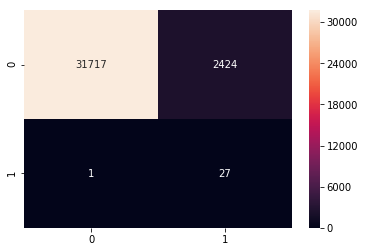

In [169]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [170]:
pd.crosstab(X_test["TIPO_EXPED"], [y_test, y_test_pred_prob > 0.5])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                158     0     0     0
1               2538     0     0     0
2              16053     0     0     0
3              12491     0     1     0
4                418    15     0     0
5                  0   249     0     5
6                 59  2160     0    22

## Tronador in test

In [162]:
y_tronador = df_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.000, 0.500


/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


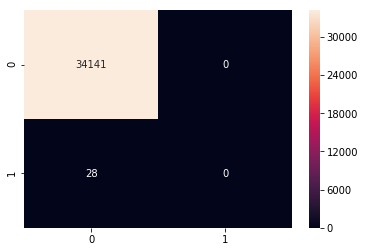

In [163]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [5]:
pd.crosstab(df_test["total_condicion"],df_test["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,1595,10
1.0,134,1
2.0,239,1
3.0,251,10
4.0,17,0
5.0,80,30
6.0,23,5
7.0,3,3
8.0,15,6
